In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as sqla
import plotly.express as px

In [3]:
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASS = "postgres"
DB_HOST = "localhost"
DB_PORT = "5432"

SQL_INIT = "railway.sql"

engine = sqla.create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Import the railway dataset

We import the `lijnsecties.geojson` dataset from infrabel (**link here**) to the database.

In [4]:
SQL_INIT = "railway.sql"

try:
    with open(SQL_INIT, "r") as f:
        query = f.read()
        with engine.connect() as conn:
            conn.execute(sqla.text(query))
        print("The table railway has been created.")
except Exception as e:
    print(e)
    exit()

The table railway has been created.


In [5]:
gdf = gpd.read_file('lijnsecties.geojson')

display(gdf.head())

,geo_point_2d,ls_id,label,ptcarfrom,ptcarfromname,ptcarto,ptcartoname,mfrom,mto,ecs_voltfreq,...,ecs_maxstandstillcurrent,ecs_minwireheight,nrtracks,c400,c70,p70,p400,symnamefrom,symnameto,geometry
0,"{ ""lon"": 6.0839040765030816, ""lat"": 50.6506363...",1541,49,382,EUPEN,993,RAEREN,5400,13257,Not Electrified,...,NaN,NaN,1,330,0,0,330,REP,RER,"LINESTRING (6.03715 50.63531, 6.04358 50.63452..."
1,"{ ""lon"": 4.221606341951353, ""lat"": 51.28712961...",1899,211(2),1459,Y.ARENBERG,1477,Y.SPAANS FRT,11284,13600,Not Electrified,...,NaN,NaN,2,400,70,70,400,YARBG,YSPFT,"LINESTRING (4.23492 51.29192, 4.2347 51.29187,..."
2,"{ ""lon"": 4.2824966026227838, ""lat"": 51.2825786...",1750,211L/5,1825,B.LIEFKENSHK,1970,Y.GESLECHT-Z,4595,5195,Not Electrified,...,NaN,NaN,1,400,70,70,400,LIEFK,YGSLZ,"LINESTRING (4.28166 51.28035, 4.28173 51.28038..."
3,"{ ""lon"": 4.2991446820369905, ""lat"": 51.2800246...",849,208,1706,Y.FARNESE-O,1808,Y.GESLECHT-O,742,5806,Not Electrified,...,NaN,NaN,1,400,70,70,400,YFNSO,YGSLO,"LINESTRING (4.28481 51.26701, 4.29342 51.26771..."
4,"{ ""lon"": 4.3085497084790916, ""lat"": 51.3035177...",711,223,1675,Y.LILLOBRUG,1676,Y.WITTEMOLEN,4790,5254,Not Electrified,...,NaN,NaN,2,400,70,70,400,YLIBR,YWIMO,"LINESTRING (4.31145 51.30409, 4.30901 51.30348..."


We will keep the columns : `geometry` (i.e., the column that contains the geopoints of lines), `label` (i.e., the name/number of the line), and `ptcarfrom` (we don't have idea of the meaning of this column, it is not explained in the source but we keep it by security it may be useful..)

In [6]:
cols_to_keep = ["label", "geometry", "ptcarfrom"]
gdf = gdf[cols_to_keep]
mapping = {"geometry": "geom", "label": "line_number", "ptcarfrom": "ptcarfrom"}
gdf = gdf.rename(columns=mapping)

gdf = gdf.set_geometry("geom")
gdf.to_postgis("railway", engine, if_exists='replace', index=False)

# Exploratory Data Analysis on map

## Percentage of delay depending of the line used by trains

In [7]:
Query = """
WITH count_delay AS (
    SELECT
        line_number_departure,
        COUNT(*) as TOTAL_COUNT,
        SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
        (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
    FROM
        train_data
    GROUP BY
        line_number_departure
)
SELECT
    cd.line_number_departure,
    cd.delay_percentage,
    r.geom
FROM
    count_delay cd
JOIN
    railway r ON cd.line_number_departure = r.line_number
"""

delay_percentage = gpd.read_postgis(Query, engine)

delay_percentage

,line_number_departure,delay_percentage,geom
0,49,10.720716,"LINESTRING (6.03715 50.63531, 6.04358 50.63452..."
1,223,50.000000,"LINESTRING (4.31145 51.30409, 4.30901 51.30348..."
2,122,7.454464,"LINESTRING (3.8147 50.8691, 3.81477 50.86917, ..."
3,211,50.000000,"LINESTRING (4.27523 51.26543, 4.27576 51.26615..."
4,132,8.002385,"LINESTRING (4.41124 50.3531, 4.41222 50.35198,..."
...,...,...,...
969,125/1,100.000000,"LINESTRING (5.46698 50.59952, 5.46694 50.59943..."
970,204,25.000000,"LINESTRING (3.74506 51.07472, 3.74559 51.07527..."
971,28(1),14.210035,"LINESTRING (4.35315 50.87801, 4.35278 50.87807..."
972,12,11.539229,"LINESTRING (4.4667 51.38974, 4.46474 51.42245,..."


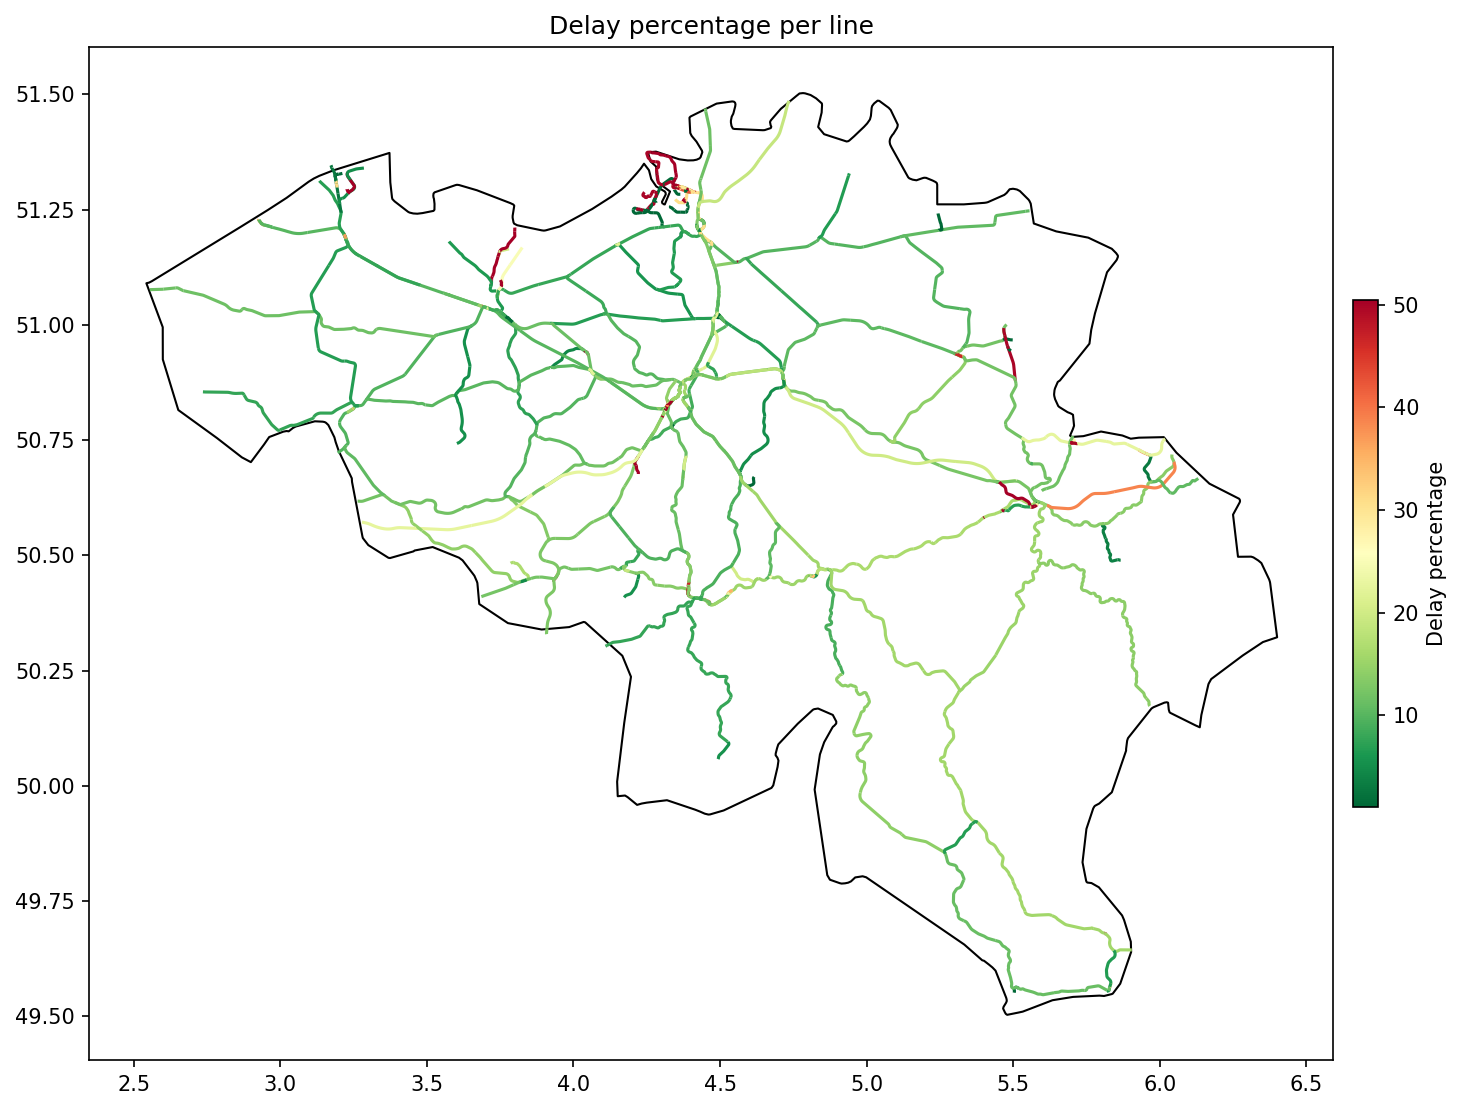

In [25]:
from matplotlib.colors import Normalize

url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

# plot heatmap of delay percentage per line number on the map
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
vmin, vmax = delay_percentage['delay_percentage'].quantile(0.05), delay_percentage['delay_percentage'].quantile(0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
delay_percentage.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
        'label': "Delay percentage",
        'shrink': 0.5,   # Reduce the size of the legend bar
        'aspect': 20,     # Make the legend bar thinner
        'pad': 0.01       # Reduce gap between plot and legend
    }, vmin=vmin, vmax=vmax)
belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
plt.title("Delay percentage per line")
plt.tight_layout()
plt.show()

# Percentage of delayed trains at stations

In [9]:
Query = """
WITH DelayedCounts AS (
    SELECT
        ptcar_name AS station_id,
        COUNT(*) AS total_count,
        SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
        (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
    FROM TRAIN_DATA
    GROUP BY ptcar_name
    HAVING COUNT(*) >= 100
)
SELECT 
    s.id, 
    s.name,
	s.geom,
    dc.total_count, 
    dc.delayed_count, 
    dc.delay_percentage
FROM DelayedCounts dc
JOIN STATIONS s ON dc.station_id = s.id
ORDER BY dc.delay_percentage DESC;
"""

delayed_stations = gpd.read_postgis(Query, engine)

delayed_stations

,id,name,geom,total_count,delayed_count,delay_percentage
0,764,VORST-RIJTUIGEN-DIENSTPERRON,POINT (4.31464 50.81765),848,591,69.693396
1,337,HASSELT-L.C.I.,POINT (5.30975 50.9369),371,244,65.768194
2,585,OOSTENDE-BUNDEL B,POINT (2.93927 51.21781),167,108,64.670659
3,537,MONCEAU-RECEPTION,POINT (4.39166 50.43599),104,62,59.615385
4,767,VORST-ZUID-SPOREN 920/926,POINT (4.31084 50.81102),1487,723,48.621385
...,...,...,...,...,...,...
713,635,RONSE,POINT (3.60261 50.74237),131960,3791,2.872840
714,701,SPA-GERONSTERE,POINT (5.86623 50.48928),119413,3249,2.720809
715,800,ZEEBRUGGE-DORP,POINT (3.19684 51.32659),72246,1940,2.685270
716,814,Zwankendamme,POINT (3.19694 51.31001),30974,696,2.247046


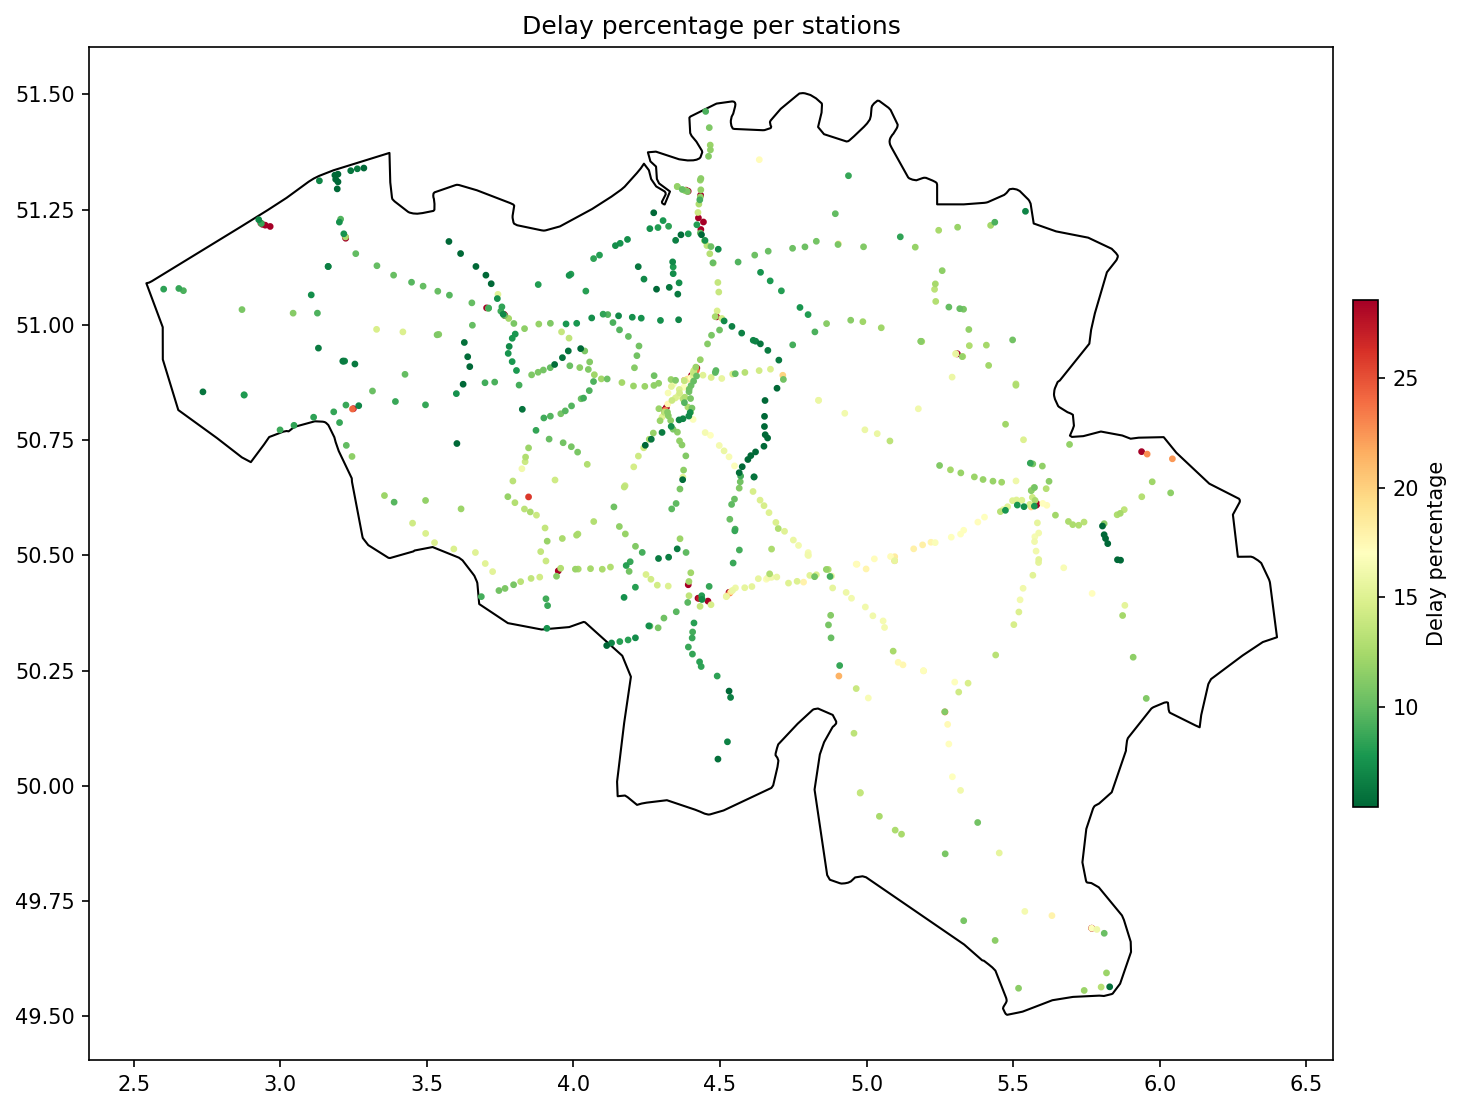

In [27]:
url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
vmin, vmax = delayed_stations['delay_percentage'].quantile(0.05), delayed_stations['delay_percentage'].quantile(0.95)
norm = Normalize(vmin=vmin, vmax=vmax)
belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
delayed_stations.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
        'label': "Delay percentage",
        'shrink': 0.5,   # Reduce the size of the legend bar
        'aspect': 20,     # Make the legend bar thinner
        'pad': 0.01       # Reduce gap between plot and legend
    }, vmin=vmin, vmax=vmax, markersize=5)
plt.title("Delay percentage per stations")
plt.tight_layout()
plt.show()

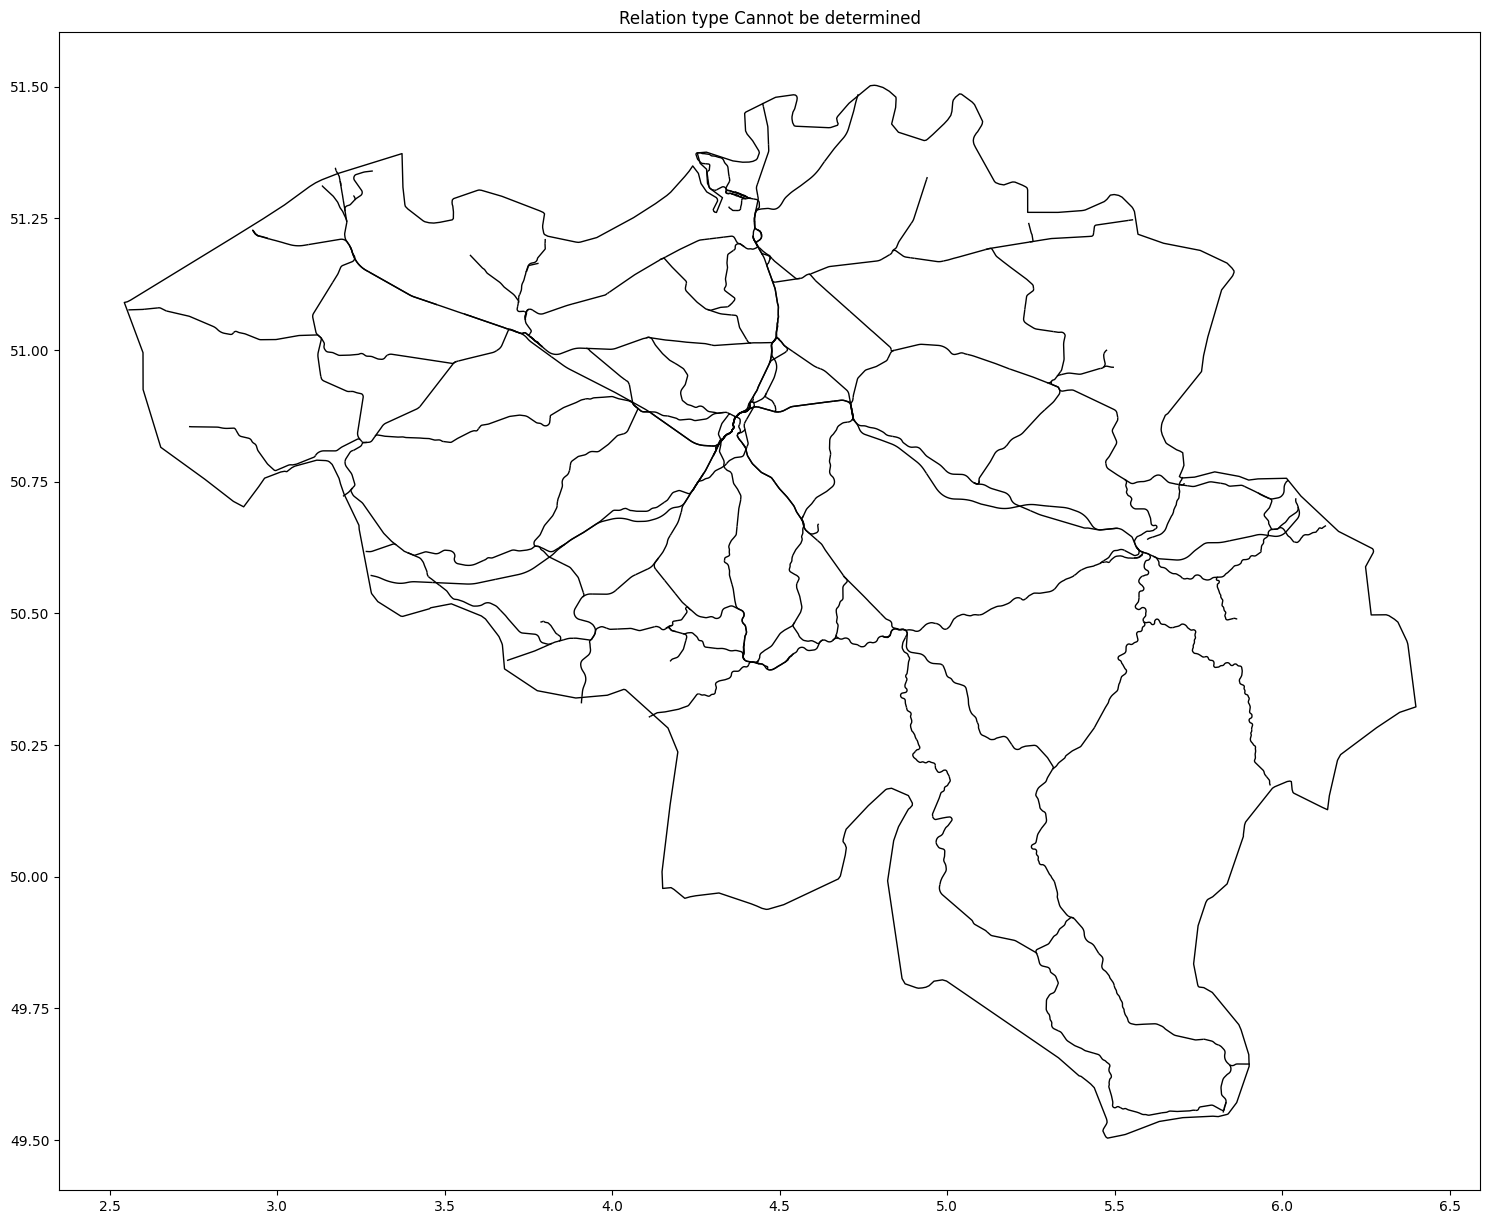

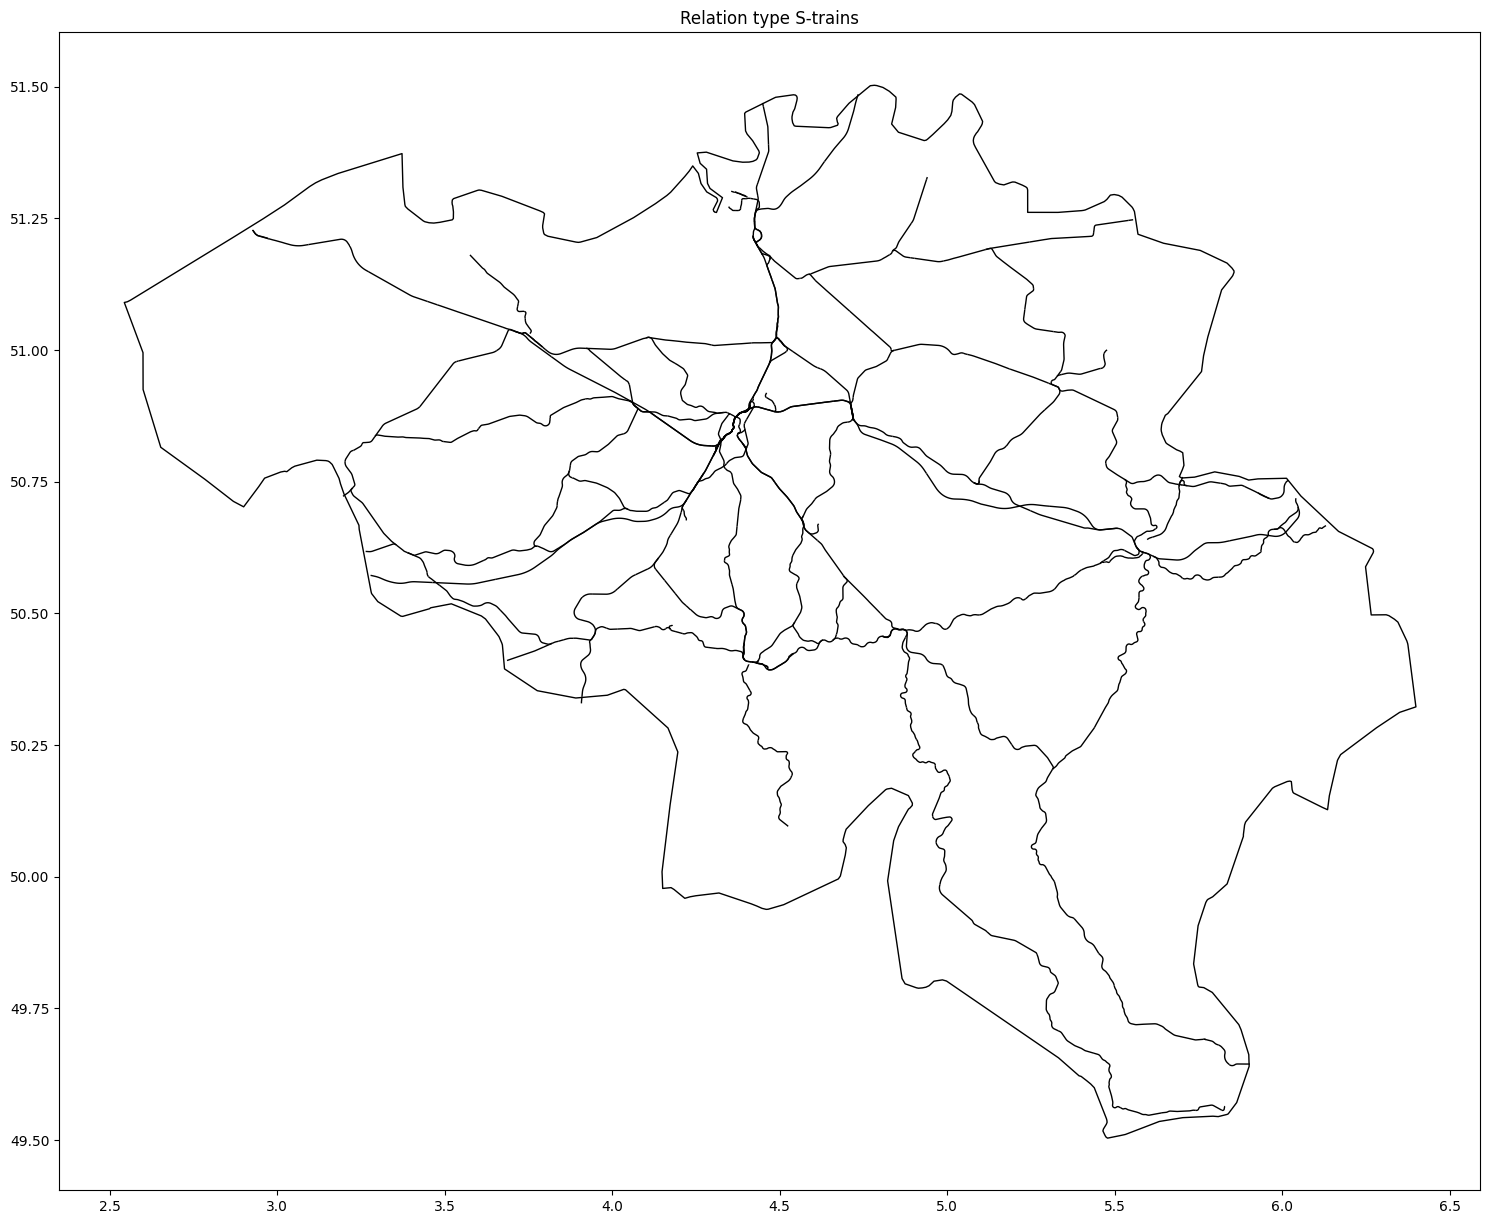

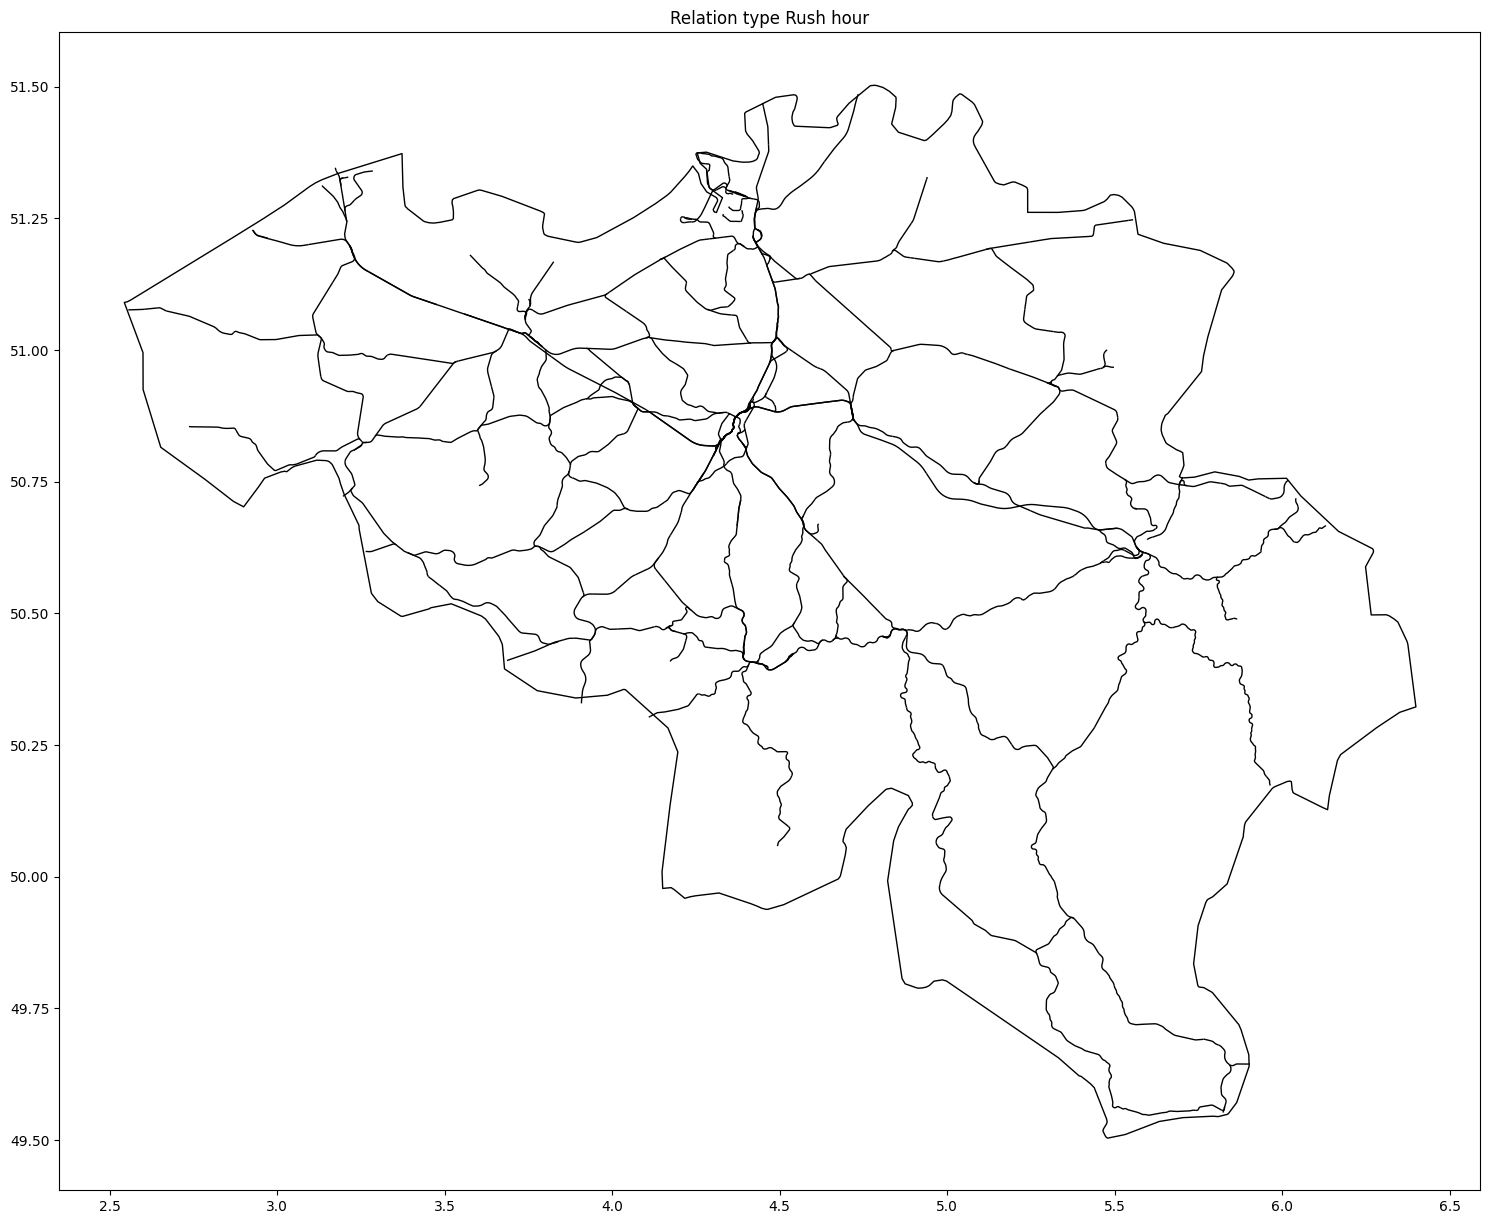

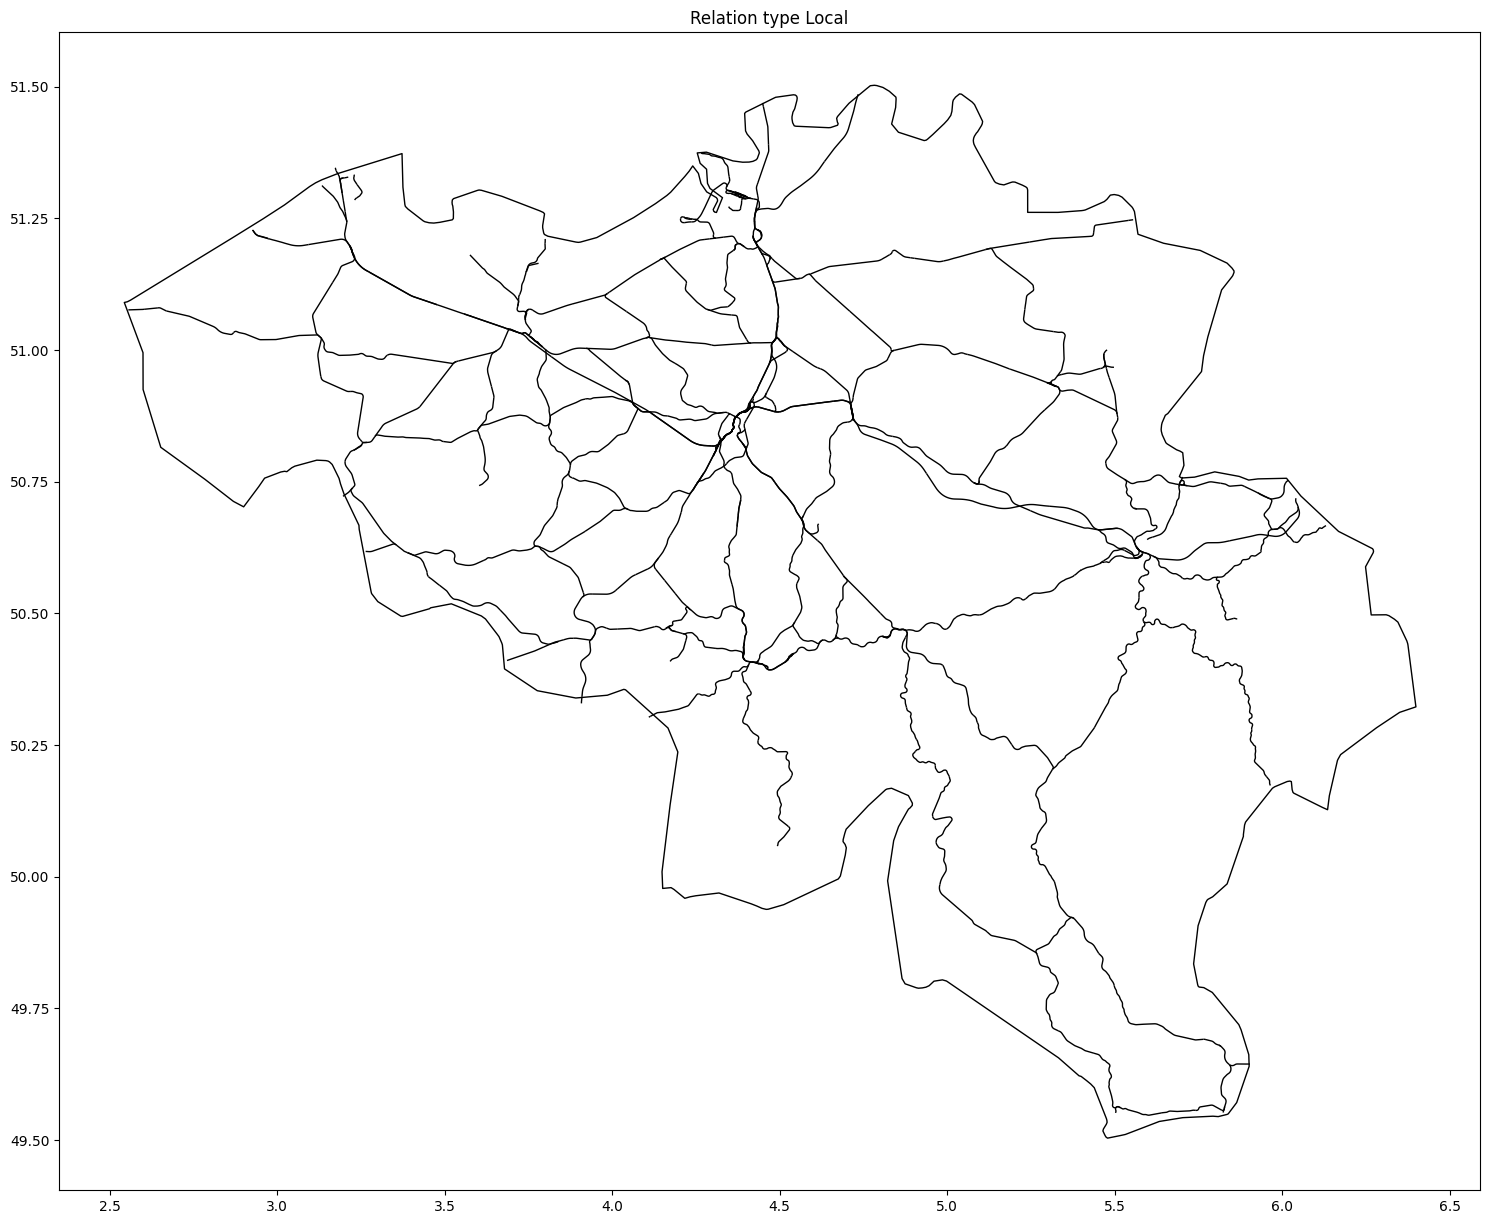

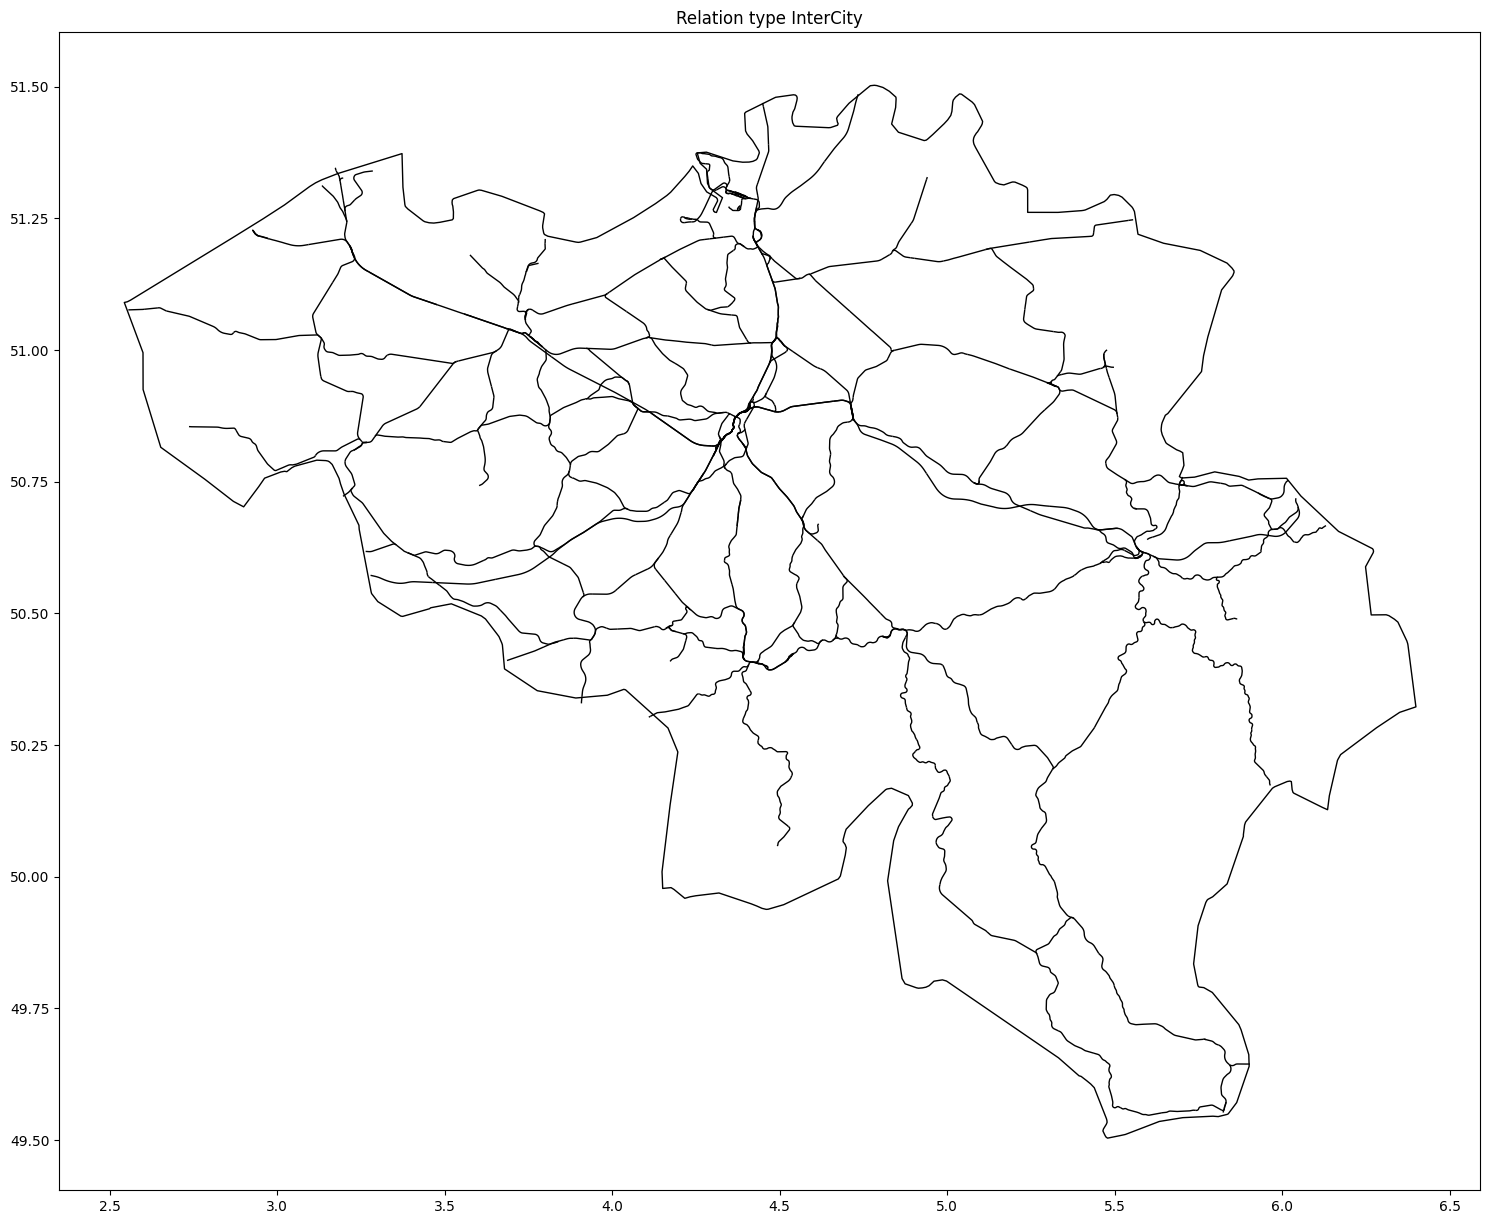

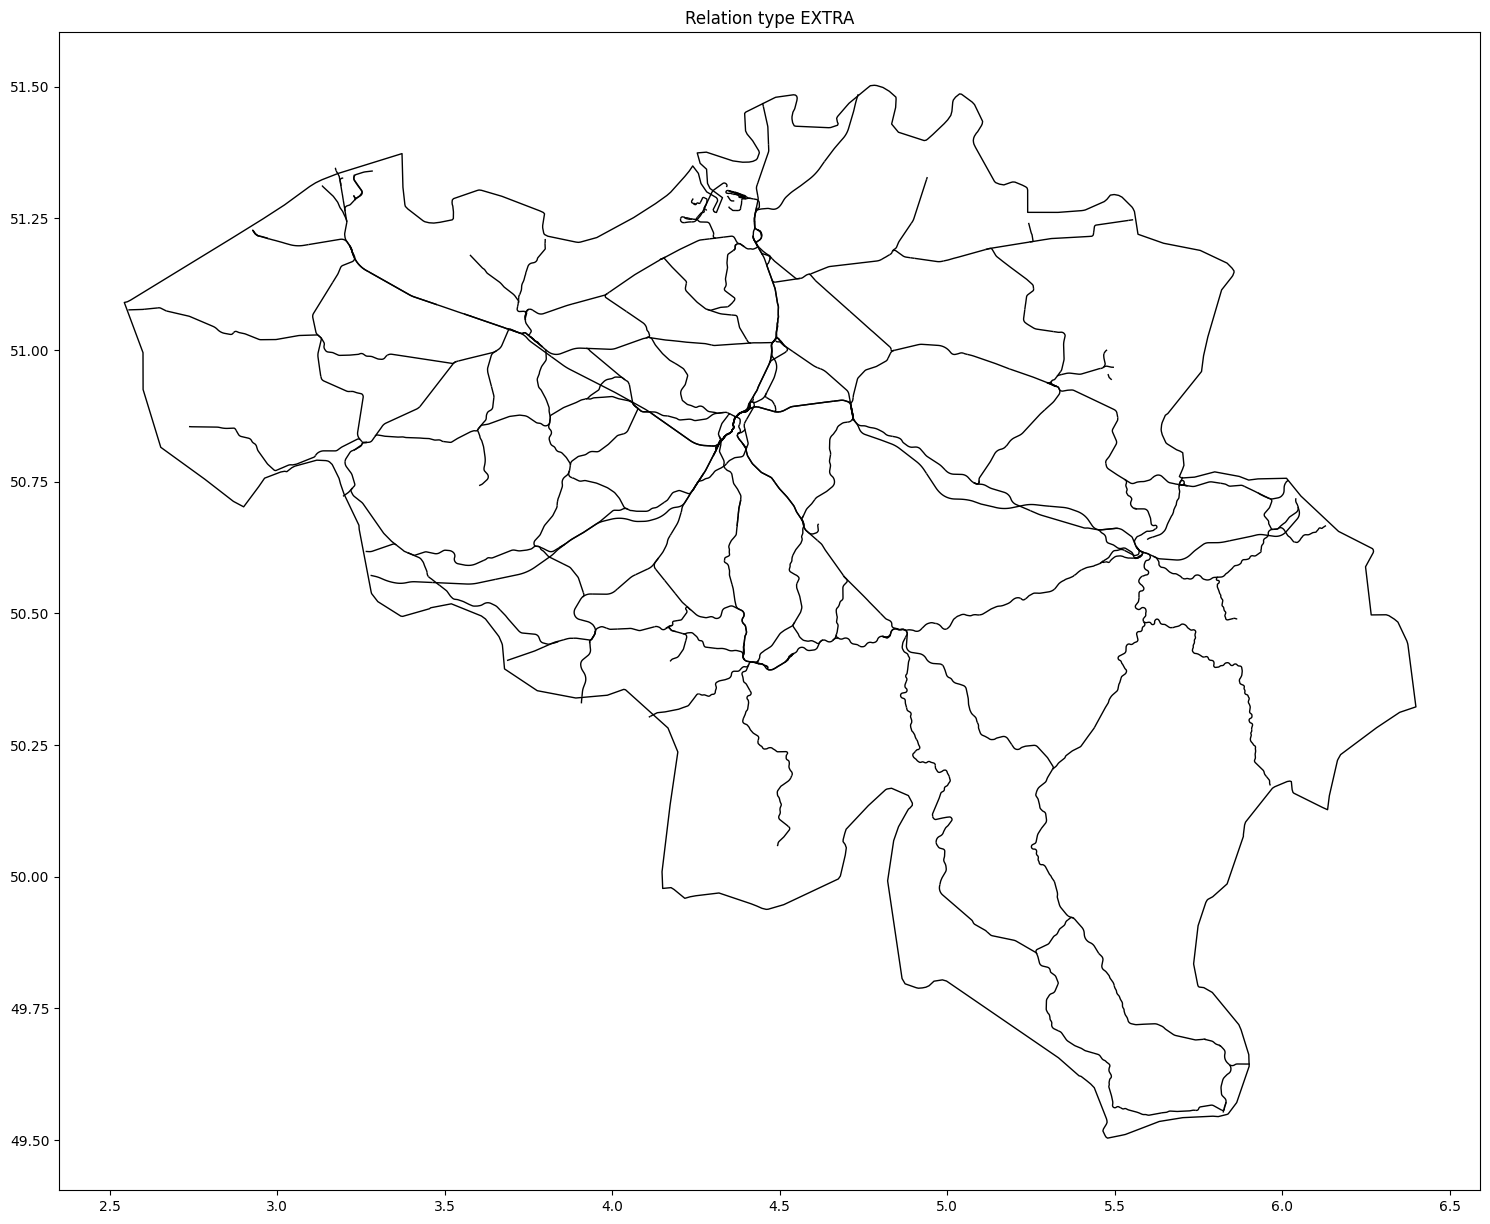

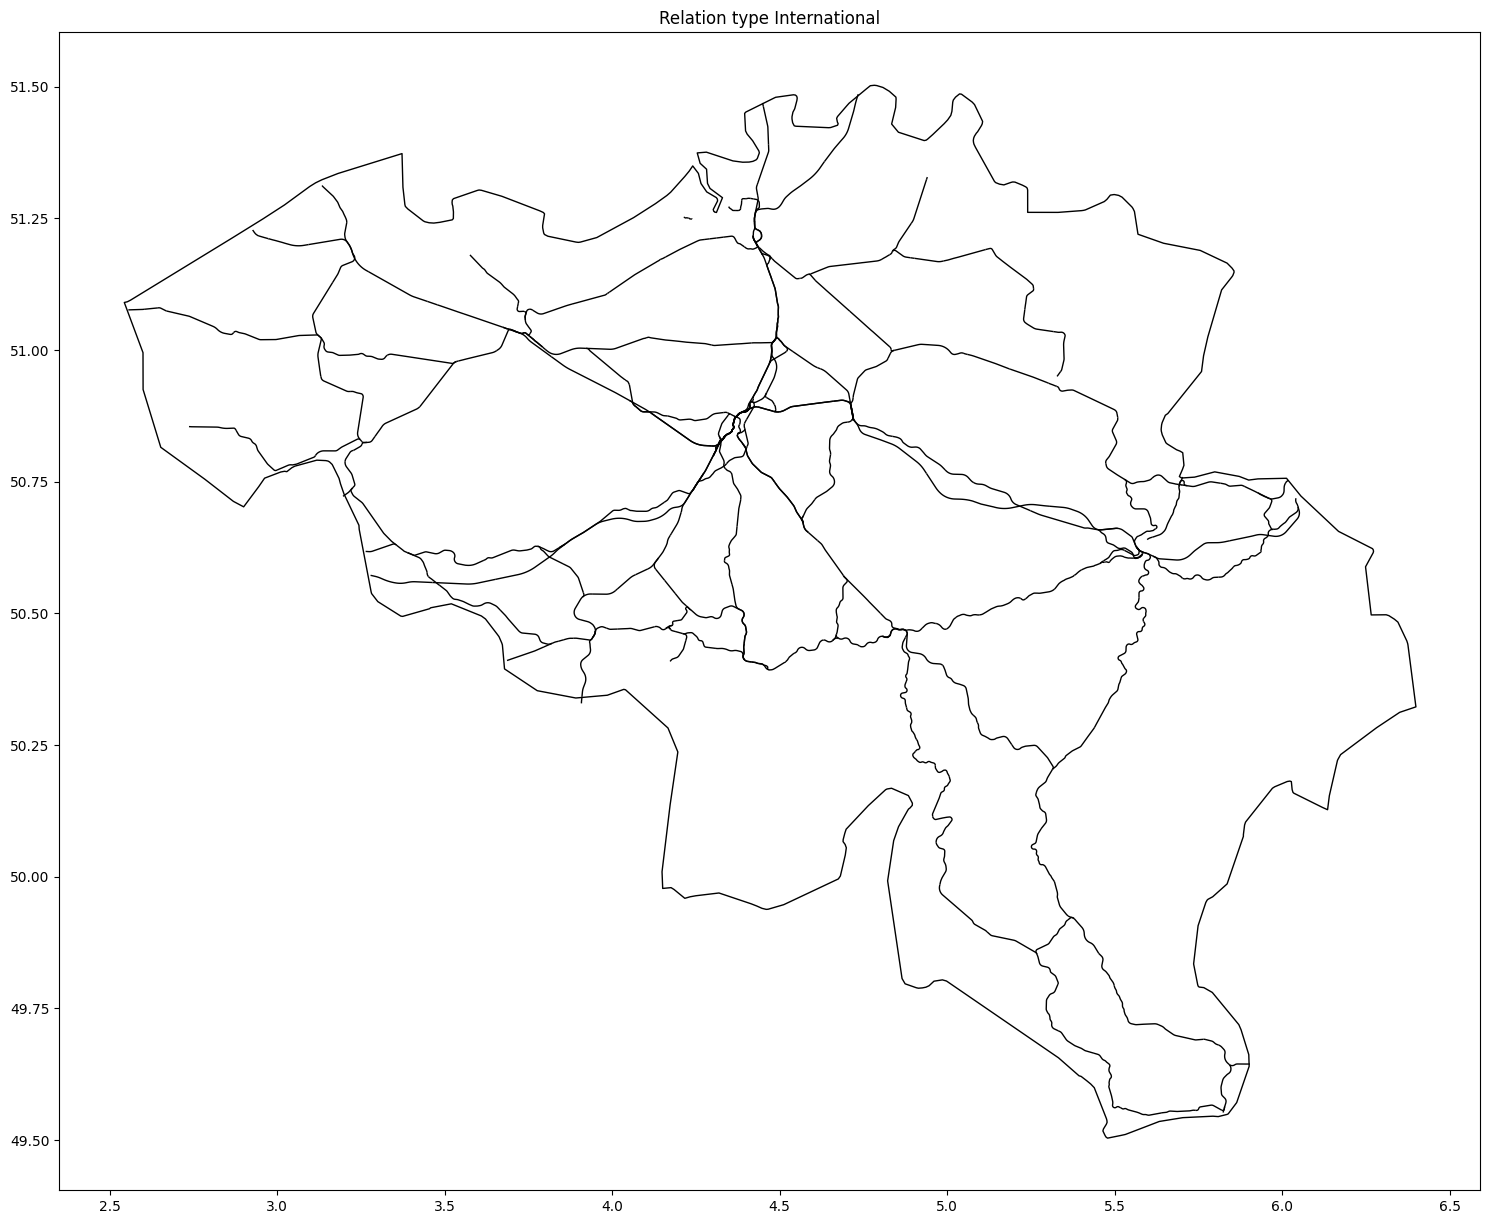

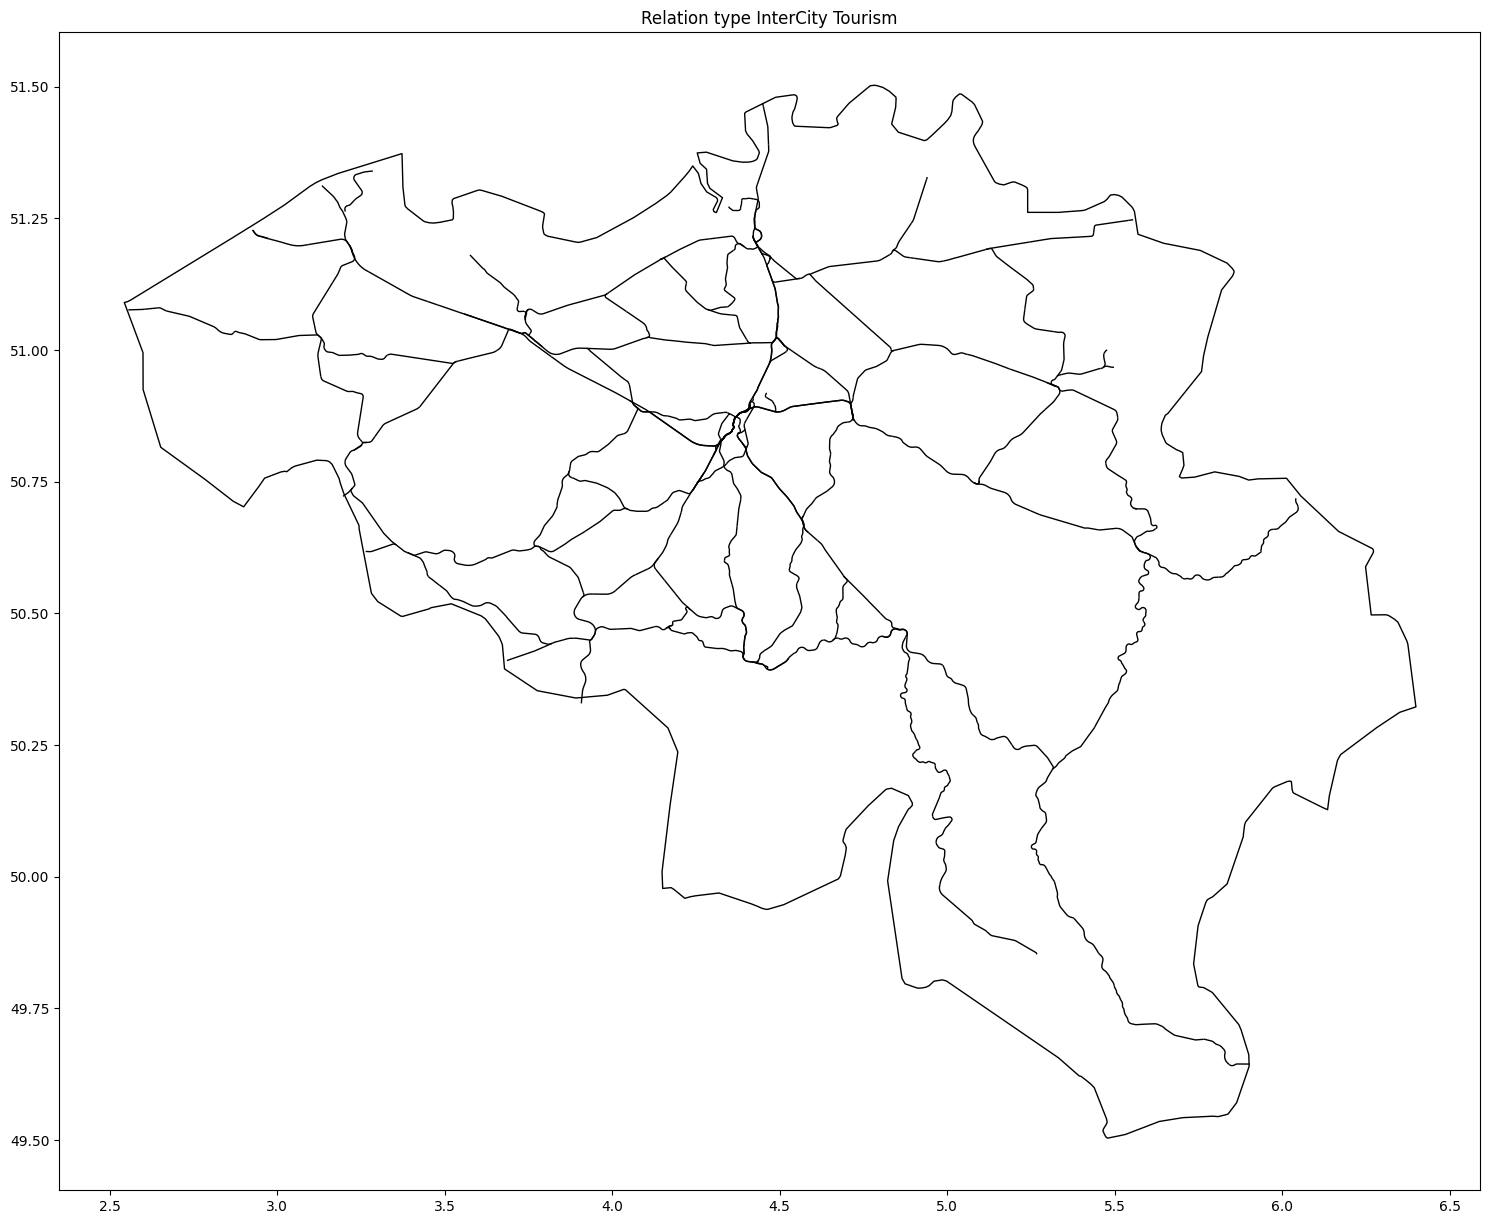

In [11]:
type_map = {
    0: "Cannot be determined",
    1: "S-trains",
    2: "Rush hour",
    3: "Local",
    4: "InterCity",
    5: "EXTRA",
    6: "International",
    7: "InterCity Tourism"
	}


url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson"
europe = gpd.read_file(url)

# Filter for Belgium
belgium = europe[europe['NAME'] == 'Belgium']

for i in range(0, 8):
	QUERY = f"""
	WITH lines AS (
		SELECT DISTINCT
			td.line_number_departure
		FROM
			train_data td
		JOIN
			relation rel on rel.id = td.relation
		WHERE
			rel.type = '{i}'    
			AND td.line_number_departure is not null
	)
	SELECT DISTINCT
		l.line_number_departure ,
		r.geom
	FROM
		lines l
	JOIN
		railway r on r.line_number = l.line_number_departure
	"""

	line_relation = gpd.read_postgis(QUERY, engine)

	fig, ax = plt.subplots(figsize=(15, 15))
	line_relation.plot(ax=ax, color='black', linewidth=1)
	belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
	plt.title(f"Relation type {type_map[i]}")
	plt.tight_layout()
	plt.show()


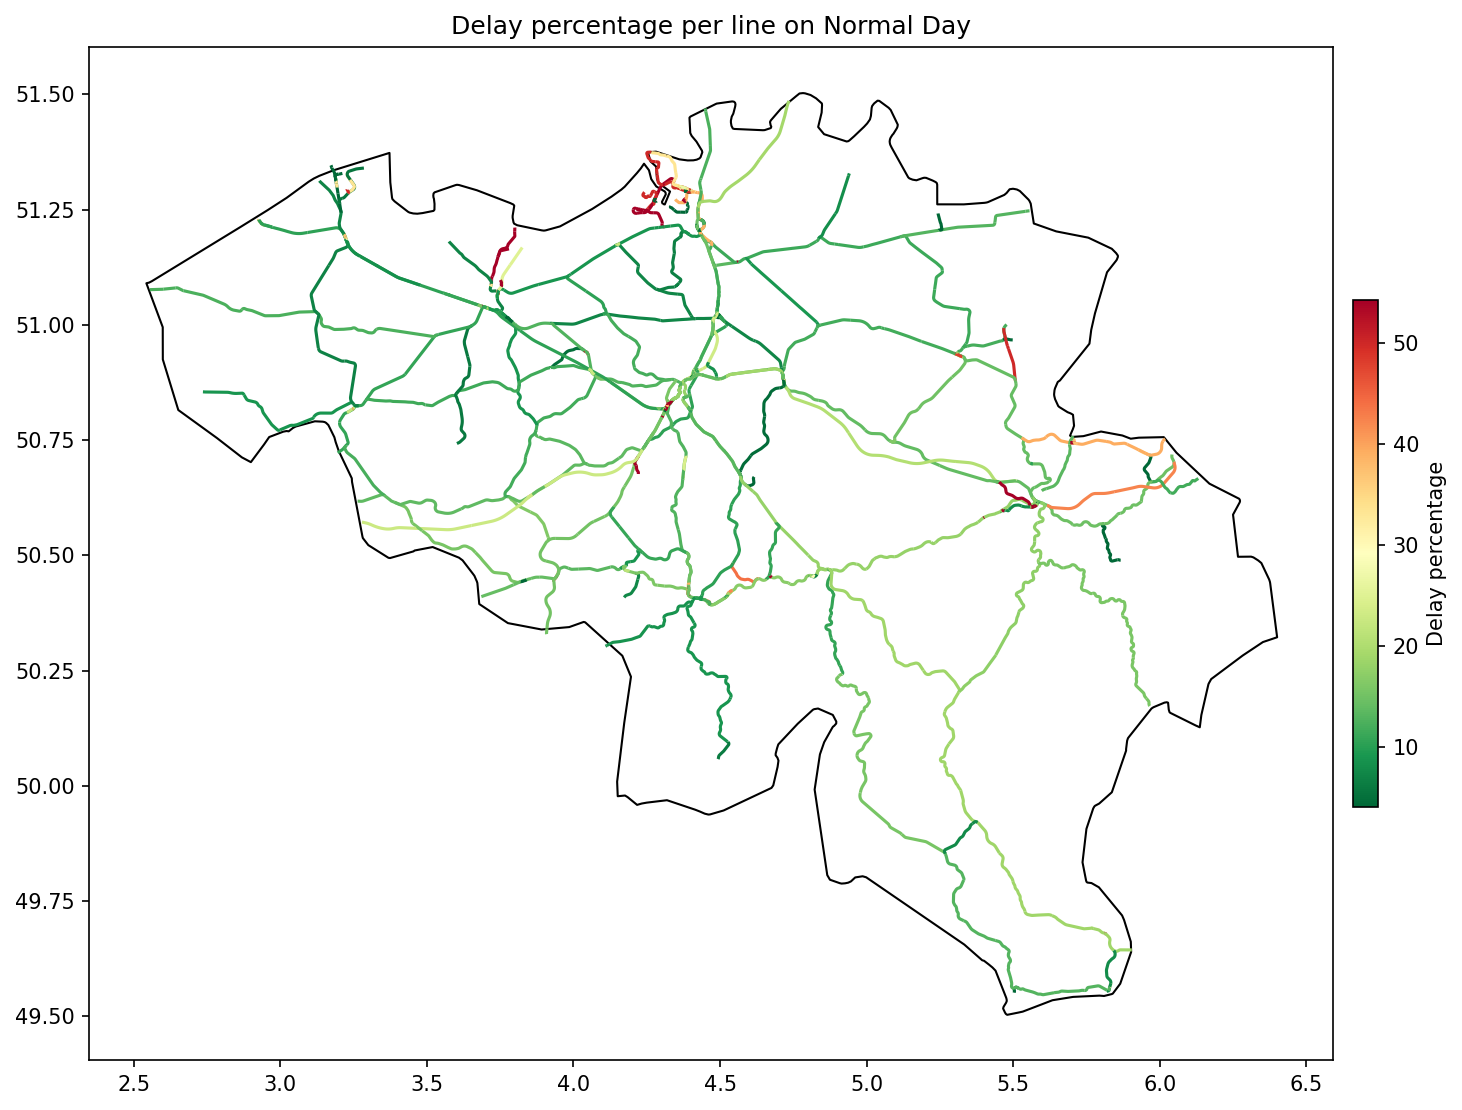

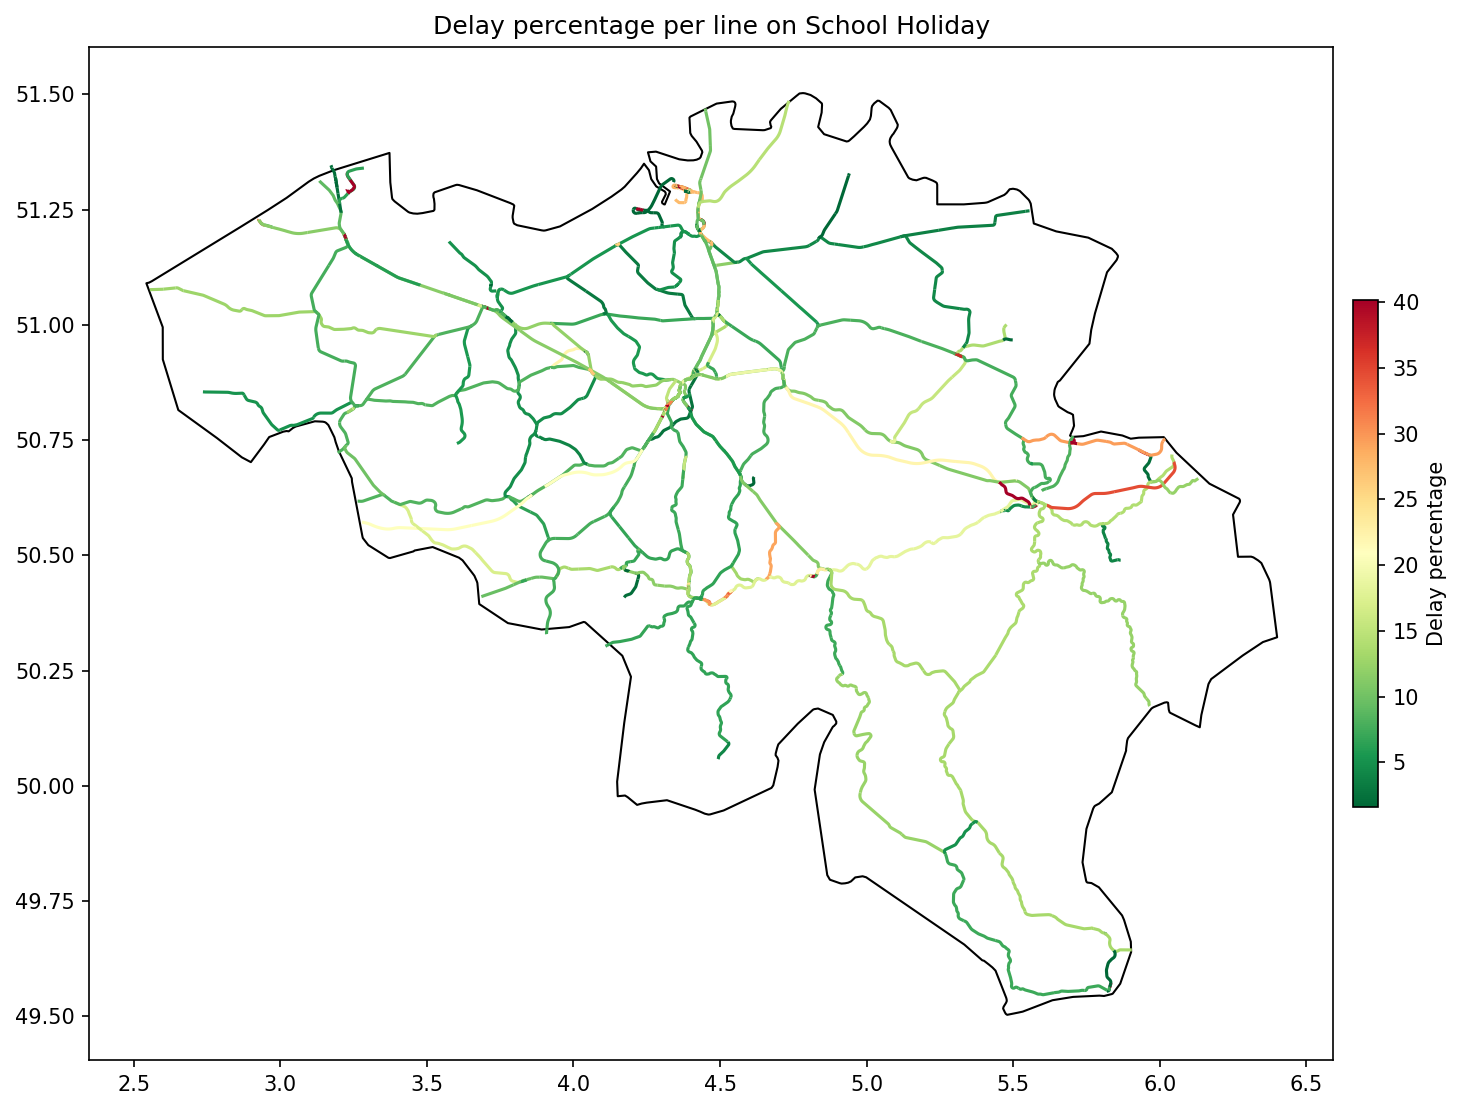

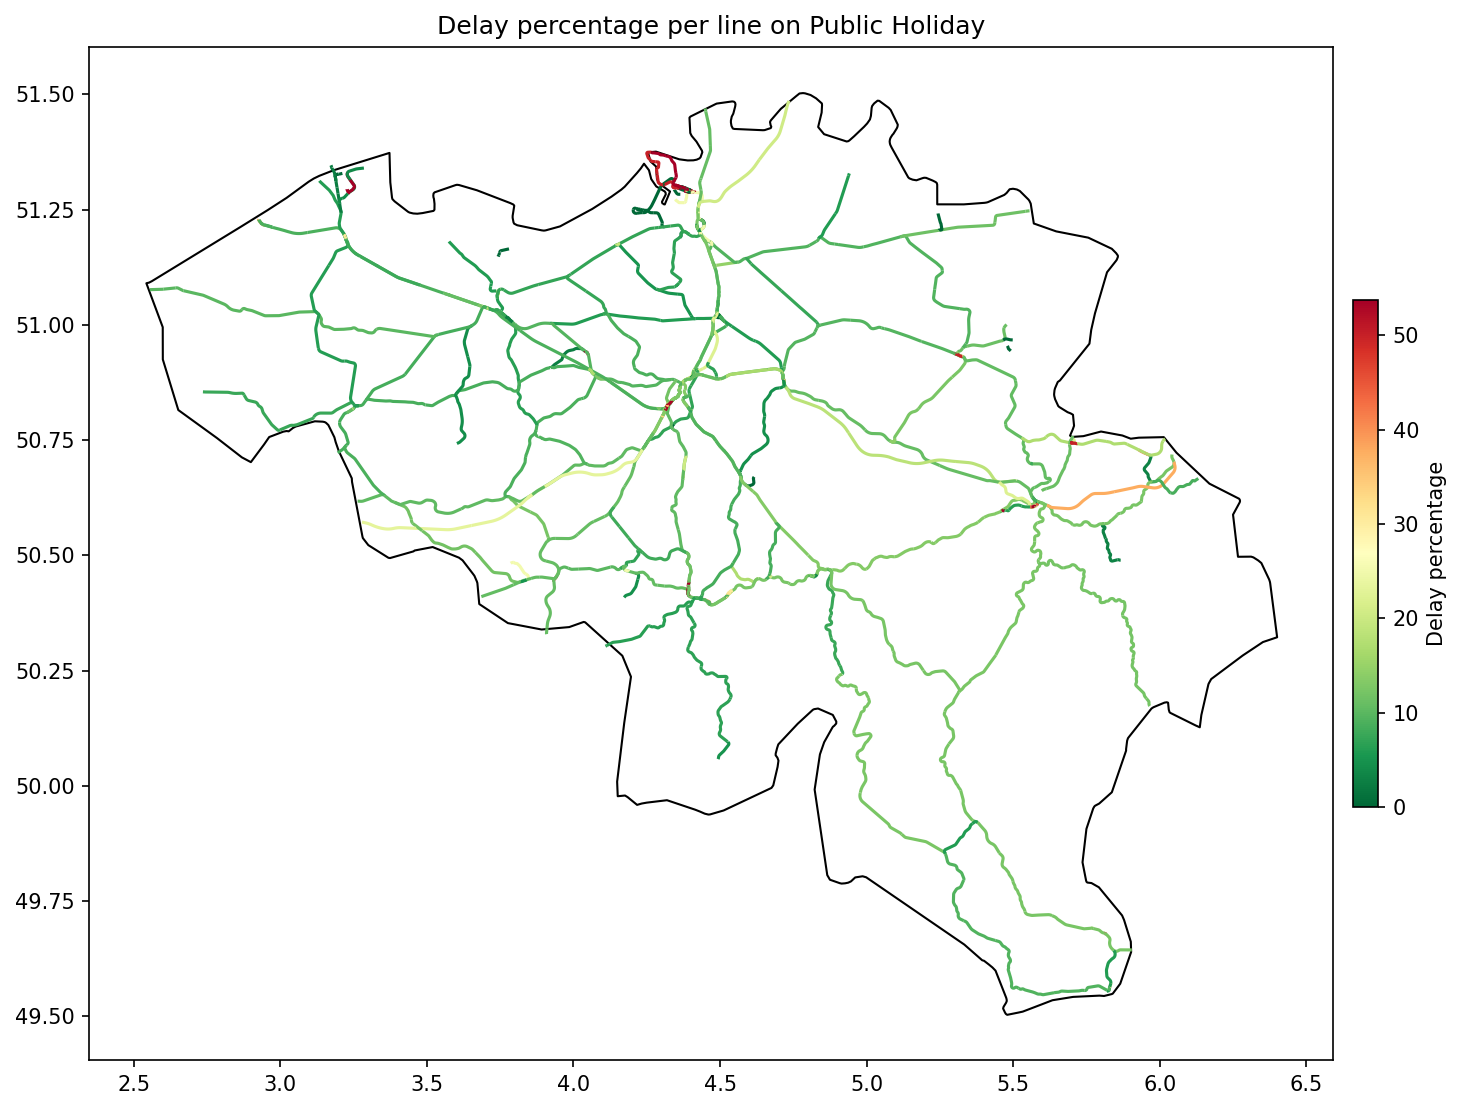

In [37]:
type_day_map = {
    0: "Normal Day",
    1: "School Holiday",
    2: "Public Holiday"
}

for i in range(0, 3):
    query = f"""
    WITH delay_counts AS (
        SELECT
            line_number_departure,
            COUNT(*) as TOTAL_COUNT,
            SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) AS delayed_count,
            (SUM(CASE WHEN delay_arrival > 300 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) AS delay_percentage
        FROM
            train_data td
        JOIN
            type_day h on h.date = td.departure_date
        WHERE
            h.holiday = '{i}'
        GROUP BY
            line_number_departure
    )
    SELECT
        cd.line_number_departure,
        cd.delay_percentage,
        r.geom
    FROM
        delay_counts cd
    JOIN
        railway r ON cd.line_number_departure = r.line_number
    """

    delay_percentage = gpd.read_postgis(query, engine)

    fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=150)
    vmin, vmax = delay_percentage['delay_percentage'].quantile(0.05), delay_percentage['delay_percentage'].quantile(0.95)
    norm = Normalize(vmin=vmin, vmax=vmax)
    delay_percentage.plot(ax=ax, column='delay_percentage', legend=True, cmap='RdYlGn_r',     legend_kwds={
            'label': "Delay percentage",
            'shrink': 0.5,   # Reduce the size of the legend bar
            'aspect': 20,     # Make the legend bar thinner
            'pad': 0.01       # Reduce gap between plot and legend
        }, vmin=vmin, vmax=vmax)
    belgium.plot(ax=ax, edgecolor='black', facecolor="white", linewidth=1)
    plt.title(f"Delay percentage per line on {type_day_map[i]}")
    plt.tight_layout()
    plt.show()